# Exercises Week 11-12: Graded exercise session (part A)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2023-2024


In [1]:
#import librairies
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom
from scipy.integrate import odeint
from scipy.special import gammaln, digamma, polygamma

**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

## Exercise 1: Transcriptional bursting

Let's consider the transcriptional process in which an mRNA $x$ is produced at a rate $s$ and degraded at a rate $k$. In addition to the simple birth-death process that we simulated in week 10, we will now consider a two-state model for the promoter (Random Telegraph process). This means that the promoter can switch from an active ($g=1$) to inactive state ($g=0$) and vice-versa with respective rates $k_{off}$ and $k_{on}$.


The Telegraph process has the following elementary reactions:  
\begin{array}{lll}
(1, n) \longrightarrow (1, n+1) \textrm{ with rate } s \\
(g, n) \longrightarrow (g, n-1) \textrm{ with rate } kn \\
(1, n) \longrightarrow (0, n) \textrm{ with rate } k_{off} \\
(0, n) \longrightarrow (1, n) \textrm{ with rate } k_{on}
\end{array}

We describe the states $(g, n)$ with $g\in \{1, 0\}$, $n \in \mathbb{N}$.

#### Question 1
1. Using the code template provided, which includes initial values and parameters, modify the Gillespie algorithm to simulate the Telegraph model. Focus on integrating the two-state model for the promoter accurately into the algorithm. You can refer to the Gillespie function from *Exercise week 10* as a starting point.

2. Systematically vary the rates (e.g increase or decrease $k$, $s$, $k_{on}$, $k_{off}$), plot representative traces and comment. Find cases that show qualitatively different behaviors.

#### Gillespie template

In [2]:
def run_gillespie_telegraph(n0, g0, parameters, t_end, DT):
    """
    Simulates the Random telepgrah process using the Gillespie algorithm.

    Parameters:
    n0 : Initial count of species n.
    g0 : Initial promoter state g (0 or 1).
    parameters: Tuple containing transcription rate s, degradation rate k, switching rates k_on and k_off
    t_end : Total simulation time.
    DT: time interval for returning/printing the output

    Returns:
    n_print : Trajectory of species n counts over time.
    g_print : Trajectory of promoter state g over time.
    t_print : Time points for each recorded reaction.
    """
    # Initialize state variables and time
    n = n0   
    g = g0   
    t = 0    
    tp = 0  

    # Initialize output lists
    n_print=[]  
    g_print=[]  
    t_print=[]  

    # Unpack parameters
    s, k, k_on, k_off = parameters 

    while t < t_end: 
        
        # Define state change matrix S and rate vector depending on promoter state
        if g == 1: # Promoter is active 
            S = np.array([[0, 1], [0, -1], [-1, 0]]) # FILL HERE
            rates = [s, n * k, k_off] # FILL HERE
        else: # Promoter is inactive
            S = np.array([[0, -1], [1, 0]]) # FILL HERE
            rates = [n * k, k_on] # FILL HERE

        # Calculate total rate and sample time to next reaction
        rates_tot = sum(rates)
        dt = np.random.exponential(scale=1.0 / rates_tot)
        t += dt

        # Determine which reaction occurs next
        rand = np.random.random()        
        rates_cumsum = np.cumsum(rates)/rates_tot

        i=0
        while rand >= rates_cumsum[i]:
            i=i+1

        # Record output (states of the system) at specified DT intervals (equally spaced output) corresponding to times before the current reaction.
        # The reason we record outputs at equally spaced time intervals is because of downstream tasks such as histograms, Fourier analysis, etc, which require equally space time sampling.
        while tp < t and t <= t_end:
            n_print.append(n)
            g_print.append(g)
            t_print.append(tp)
            tp += DT

        # Update species n counts and promoter state g
        chosen_react=i
        g += S[chosen_react,0]
        n += S[chosen_react,1]

    return n_print, g_print, t_print

In [3]:
def plot_gillespie_telegraph(n, g, t, parameters='unprovided', h_asymp=False, half_life=False):
    """
    Plots the Random telepgrah process using the Gillespie algorithm.

    Parameters:
    n: Species n counts over time.
    g: Promoter state g over time.
    t: Time points for each recorded reaction.

    """

    fig, axs = plt.subplots(2, figsize=(15, 5), sharex=True)

    # Plotting the number of molecules n over time
    axs[0].plot(t, n, label = 'n(t)', color='darkblue')
    axs[0].set_ylabel('# molecules n')

    # Plotting the promoter activity over time
    axs[1].vlines(x=t, ymin=0, ymax=np.array(g), colors='teal', lw=2, label='promoter activity')
    axs[1].set_ylim(0, 1.1)  # Set y-limits to make the promoter states clear (0 and 1)
    axs[1].set_ylabel('Promoter State')
    
    # Plotting the horizontal asymptote if provided as an argument to highlight the limit the system reaches
    if h_asymp != False:
        if half_life != False:
            # Displaying the half life of the molecule if provided as an argument
            x_hl, y_hl = half_life, h_asymp / 2
            axs[0].plot(x_hl, y_hl, 'r+')
            text = "(log(2)/k, s/2k) = (" + str(x_hl)[0:5] + ', ' + str(y_hl)[0:4] + ')'
            axs[0].text(x_hl, y_hl - 1000, text)
        h_asymp = [h_asymp] * len(t)
        axs[0].plot(t, h_asymp, '--')    
    
    # Displaying used parameters in the title of the figure
    plt.suptitle("Simulation results with parameters: " + parameters, fontsize=18)
    
    # Common x-label
    plt.xlabel('time')
    
    plt.show()

In [4]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
n_0 = 20 # Initial count of species n

DT = 0.01 # Time interval for returning/printing the output
t_end = 1000 #Total simulation time in minutes

## ANSWER TO QUESTION 1.2 :

### Simple birth-death process 
If $k_\textrm{off} \ll k_\textrm{on}$ or $k_\textrm{off} = 0$ and $s \gg k$ then the promoter is stuck into the "ON" state, and synthesis is always possible. The population follows a simple birth-death process. We obtain the classical increasing exponential. We verify that the **final value** is $\frac{s}{k}$ and that the **half-life** is equal to $\frac{\log 2}{k}$. We represent the half life with a red point and give its coordinates.

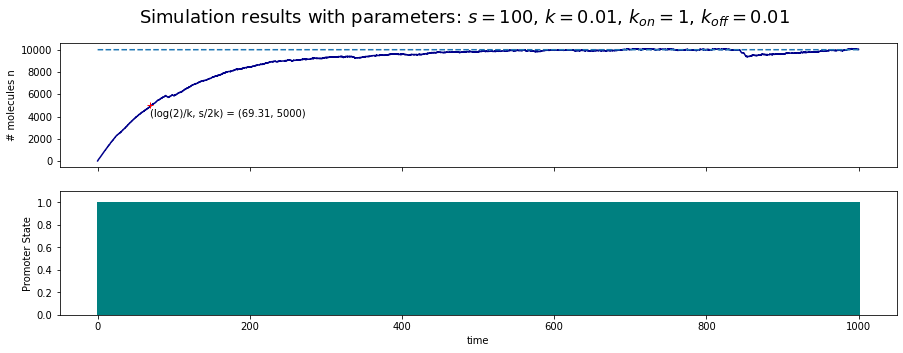

In [5]:
#Parameters for a SIMPLE BIRTH-DEATH PROCESS
s = 100 # Number of initiations per minute
k = 1/100 # Degradation rate, 1/k = 100 min
k_on  = 1 #Switching on rate, t_off = 1/k_on = 1 min
k_off = 1/100 #Switching off rate, t_on = 1/k_off = 100 min

parameters = [s, k, k_on, k_off]

# Run Gillespie simulation
n_bd, g_bd, t_bd = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Plot the results
plot_gillespie_telegraph(n_bd, g_bd, t_bd, parameters="$s=100$, $k=0.01$, $k_{on}=1$, $k_{off}=0.01$", h_asymp=s/k, half_life=np.log(2)/k)

### Constant stochastic expression
As a particlar case of the birth-death process with a promoter stuck in "ON" state, by setting $k_\textrm{off} \ll k_\textrm{on}$ or $k_\textrm{off} = 0$ and $s \simeq 10 \times k$ we obtain a classical stochastic expression. The average expression value is constant over time and equal to $\frac{s}{k}$ but very noisy around this value. This later gives a **Poisson distribution** around $\frac{s}{k}$.

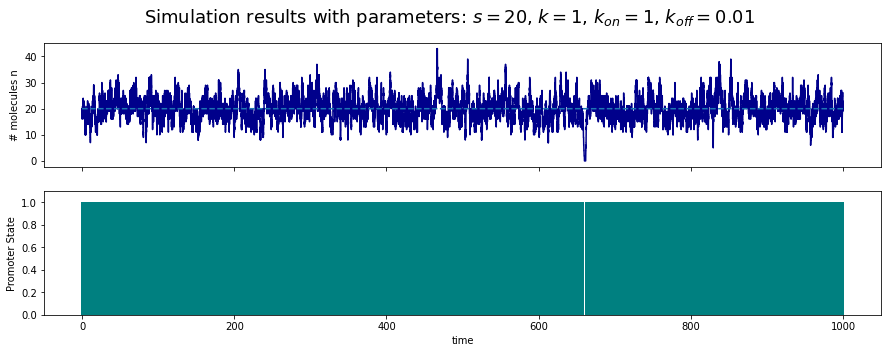

In [14]:
#Parameters for a CONSTANT STOCHASTIC EXPRESSION
s = 20 # Number of initiations per minute
k = 1 # Degradation rate, 1/k = 1 min
k_on  = 1 #Switching on rate, t_off = 1/k_on = 1 min
k_off = 1/100 #Switching off rate, t_on = 1/k_off = 100 min

parameters = [s, k, k_on, k_off]

# Run Gillespie simulation
n_const, g_const, t_const = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Plot the results
plot_gillespie_telegraph(n_const, g_const, t_const, parameters="$s=20$, $k=1$, $k_{on}=1$, $k_{off}=0.01$", h_asymp=s/k)

### Burst Approximation
If $k_\textrm{on} \ll k_\textrm{off}$ and $s \rightarrow +\infty$, the population follows the bursting approximation. Expression is occasionnaly ON and for a short amount of time, but when it is, synthesis is very strong. Analysis of the distribution of such a population would give a **negative binomial distribution.**

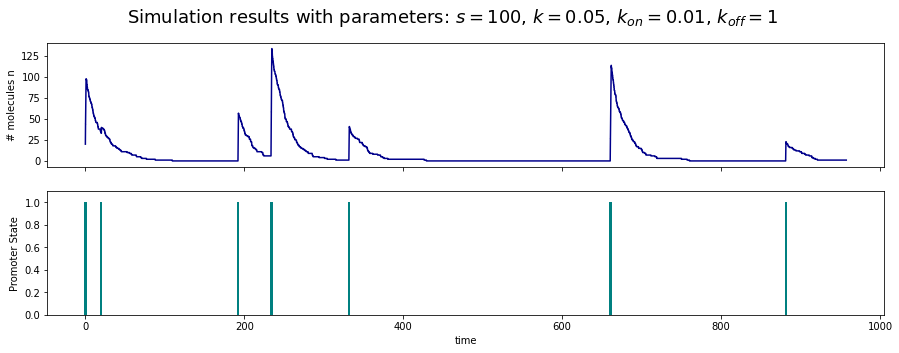

In [18]:
#Parameters for a BURST APPROXIMATION
s = 100 # Number of initiations per minute
k = 1/20 # Degradation rate, 1/k = 20 min 
k_on  = 1/100 #Switching on rate, t_off = 1/k_on = 100 min
k_off = 1 #Switching off rate, t_on = 1/k_off = 1 min

parameters = [s, k, k_on, k_off]

# Run Gillespie simulation
n_burst, g_burst, t_burst = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Plot the results
plot_gillespie_telegraph(n_burst, g_burst, t_burst, parameters="$s=100$, $k=0.05$, $k_{on}=0.01$, $k_{off}=1$")

### Slow-Rate Approximation:
If $k_\textrm{off}$, $k_\textrm{on} \ll k$ we reach the slow rate approximation, where the promoter switches rarely, and is stuck for a long period in the state it reached. **It has hence the time to reach the corresponding stationary state**, and this is why we see alternance between periods where the number of mRNA is about $\frac{s}{k}$ (stationary distribution for the "ON" case) and where it is 0 (stationary distribution for the "OFF" case).

We can also remark that the repartition between "ON" and "OFF" states depends on the ratio between $k_\textrm{on}$ and $k_\textrm{off}$. 
The cell has probability $p_\textrm{on}=\frac{k_\textrm{on}}{k_\textrm{on}+k_\textrm{off}}$ to be "ON" and probability $p_\textrm{off}=\frac{k_\textrm{off}}{k_\textrm{on}+k_\textrm{off}}$ to be "OFF". This is why in the graph below, we see the promoter being in state "ON" twice more than in state "OFF".

As a final distribution, we hope to see two peaks, one in the region $0$ corresponding to the "OFF" stationary distribution, and one in the region $\frac{s}{k}$ corresponding to the Poisson stationary distribution of the "ON" state, leading to a **bimodal distribution**.

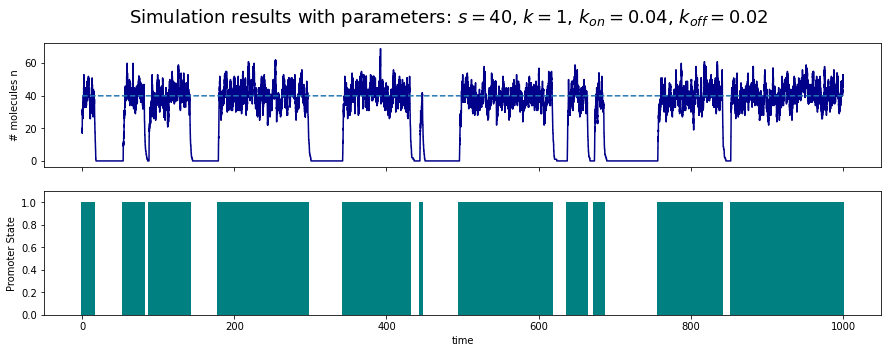

In [8]:
#Parameters for a SLOW RATE APPROXIMATION
s = 40 # Number of initiations per minute
k = 1 # Degradation per minut
k_on  = 1/25 #Switching on rate, t_off = 1/k_on = 20 min
k_off = 1/50 #Switching off rate, t_on = 1/k_off = 40 min

parameters = [s, k, k_on, k_off]

# Run Gillespie simulation
n_slow, g_slow, t_slow = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)

# Plot the results
plot_gillespie_telegraph(n_slow, g_slow, t_slow, parameters="$s=40$, $k=1$, $k_{on}=0.04$, $k_{off}=0.02$",h_asymp=s/k)

#### Question 2
1. Study the distribution of mRNA numbers generated by your simulation. Identify a parameter regime that results in a Poisson distribution of mRNA numbers. Show the empiral histogram and overlay an exact Poisson distribution and comment.

2. Find parameters where the mRNA distribution deviates from the Poisson (e.g. a Negative Binomial distribution). Discuss why these changes lead to a different distribution. 

3. For parameters that yield an approximate Poisson distribution, discuss how the parameters of the Telegraph model relate to the parameters of the Poisson distributions. 

4. Show a set of parameters that leads to a bimodal distribution of mRNA numbers.  


####  Helper functions for the Poisson and Negative Binomal distributions along with personnalized functions

In [9]:
# Poisson distribution
def Poisson(lam, counts):
    """
    Calculate the Poisson distribution probability for given counts.
    
    Parameters:
    lam: The average number of events (rate parameter).
    counts: Observed counts.

    Returns:
    np.array: Probabilities corresponding to the observed counts.

    Notes:
    - This function uses the log-form of the Poisson probability mass function.
    - The gammaln function is used for calculating the logarithm of the factorial term.

    """

    logp = counts * np.log(lam) - lam - gammaln(counts + 1)
    return np.exp(logp)

# Negative Binomial distribution
# This may not be needed for the exercise, but it is included for completeness
def convert_params(mu, theta):
    """

    Convert mean and dispersion parameters to the shape and probability parameters of the negative binomial distribution.
    
    Parameters:
    mu: Mean of the distribution.
    theta: Dispersion parameter.

    Returns:
    tuple: Shape parameter (r) and success probability (p) of the negative binomial distribution.

    Notes
    - This conversion is necessary because different parameterizations are used in different contexts.

    """
    #r = theta
    #var = mu + 1 / r * mu ** 2
    #p = (var - mu) / var
    #return r, 1 - p
    
    p=mu/theta
    r=mu**2/theta/(1-p)
    return r,p

def pmf_nb(counts, mu, theta):
    """
    Compute the probability mass function of the negative binomial distribution for given counts.

    Parameters:
    counts: Observed counts.
    mu: Mean of the distribution.
    theta: Dispersion parameter.

    Returns:
    np.array: Probabilities corresponding to the observed counts.
    """


    return nbinom.pmf(counts, *convert_params(mu, theta))



# Helper functions of our own contribution
# faster algorithm of the telegraph model thanks to approximation to a beta distribution

# personnalized kroenecker delta function
def u(n_max=30):
    z=np.zeros(n_max)
    z[0]=1
    return z

## ANSWER TO QUESTION 2.1 and 2.3 : Poisson distribution

Considering our previous analysis, we hope the constant stochastic expression ($k_\textrm{off}<<k_\textrm{on}$, $s\approx 10 k$) to lead to Poisson distribution in its stationary state. The corresponding parameter should be the stationary distribution for the corresponding birth death process, with birth rate $s$ and death rate $k$, so **the parameter is $\frac{s}{k}$**. 

In practice, since the poisson distribution's parameter is equal to the mean and to the variance of the distribution, we can verify our hypothesis by plotting $\frac{s}{k}$, the mean of our distribution and its variance while changing the parameters.

Our findings are found to be really consistants.

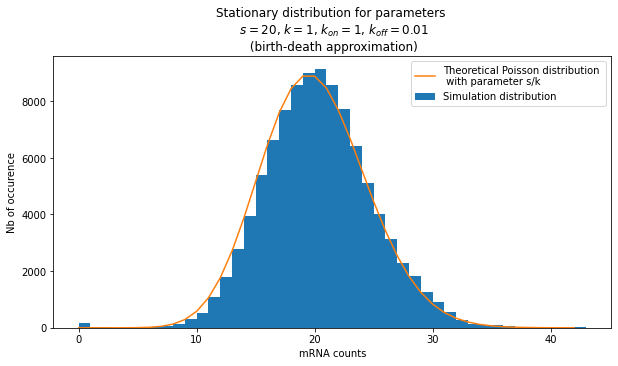

In [16]:
#Parameters for a CONSTANT STOCHASTIC EXPRESSION
s = 20 # Number of initiations per minute
k = 1 # Degradation rate, 1/k = 1 min
k_on  = 1 #Switching on rate, t_off = 1/k_on = 1 min
k_off = 1/100 #Switching off rate, t_on = 1/k_off = 100 min

max_count = max(n_const)
nb_counts = len(n_const)
possible_counts = np.array(range(max_count))

plt.figure(figsize=(10,5))
plt.xlabel("mRNA counts")
plt.ylabel("Nb of occurence")
plt.hist(n_const,bins=max_count)
plt.plot(possible_counts,Poisson(s/k,possible_counts)*nb_counts)
plt.title("Stationary distribution for parameters \n $s=20$, $k=1$, $k_{on}=1$, $k_{off}=0.01$\n (birth-death approximation)")
plt.legend(["Theoretical Poisson distribution \n with parameter s/k","Simulation distribution"])

plt.show()

## ANSWER TO QUESTION 2.2 : Negative binomial distribution

The bursting approximation ($k_\textrm{on}<<k_\textrm{off}$, $s\rightarrow +\infty$) is a good candidate for a stationary distribution of the mRNA count $M$ rather different than the Poisson one, because of its really different behaviour. Using the ’convert_params’ function to get the value of the parameters, we obtain the plot below, which is consistent with our hypothesis.

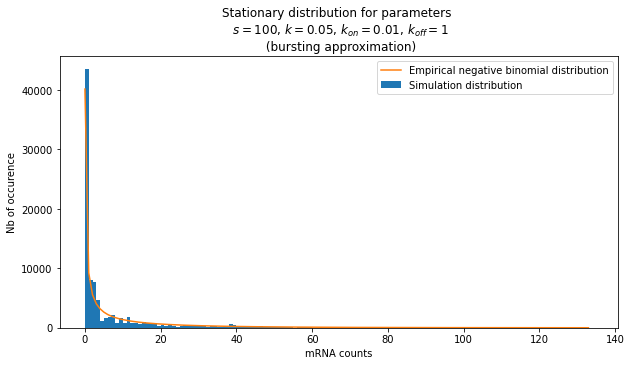

In [19]:
#Parameters for a BURST APPROXIMATION
s = 100 # Number of initiations per minute
k = 1/20 # Degradation rate, 1/k = 20 min 
k_on  = 1/100 #Switching on rate, t_off = 1/k_on = 100 min
k_off = 1 #Switching off rate, t_on = 1/k_off = 1 min

n_burst=np.array(n_burst)
max_count = max(n_burst)
nb_counts = len(n_burst)
possible_counts = np.array(range(max_count))

plt.figure(figsize=(10,5))
plt.xlabel("mRNA counts")
plt.ylabel("Nb of occurence")
plt.hist(n_burst,bins=max_count)
plt.plot(possible_counts,pmf_nb(possible_counts,n_burst.mean(),n_burst.var())*nb_counts)
plt.title("Stationary distribution for parameters \n $s=100$, $k=0.05$, $k_{on}=0.01$, $k_{off}=1$\n (bursting approximation)")
plt.legend(["Empirical negative binomial distribution","Simulation distribution"])

plt.show()

To go a little bit further, the value of the parameters of this negative binomial are given by 
$$p=k_\textrm{on} ; r=\frac{1}{1+\frac{s}{k_\textrm{off}}}.$$
(refer to [1] for explanation).

## ANSWER TO QUESTION 2.4 : Bimodal distribution

If $k_\textrm{off}$, $k_\textrm{on} \ll k$, the slow rate approximation should lead to a superposition of two distribution : a peak for small mRNA counts near 0, representing the cases where the promoter is stuck in the OFF mode (represented by our hand-made "dirac" function, in green) and a poisson distribution centered on $\frac{s}{k}$, representing the behaviour of the gene expression when the gene is in the ON mode (orange curve).

Both curve should be weighted according to the time the gene spend in average in each of these states, this is why we gave a weight of $p_\textrm{on}=\frac{k_\textrm{on}}{k_\textrm{on}+k_\textrm{off}}$ for the dirac, and a weight of $p_\textrm{off}=\frac{k_\textrm{off}}{k_\textrm{on}+k_\textrm{off}}$ for the poisson distribution.

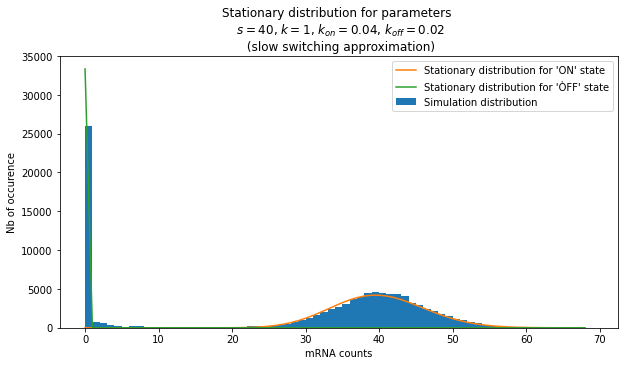

In [12]:
#Parameters for a SLOW RATE APPROXIMATION
s = 40 # Number of initiations per minute
k = 1 # Degradation rate, 1/k = 0.5 min
k_on  = 1/25 #Switching on rate, t_off = 1/k_on = 20 min
k_off = 1/50 #Switching off rate, t_on = 1/k_off = 40 min



max_count = max(n_slow)
nb_counts = len(n_slow)
possible_counts = np.array(range(max_count))

p_on = k_on/(k_on+k_off)
p_off = k_off/(k_on+k_off)

plt.figure(figsize=(10,5))
plt.xlabel("mRNA counts")
plt.ylabel("Nb of occurence")
plt.hist(n_slow,bins=max_count)
plt.plot(possible_counts,Poisson(s/k,possible_counts)*p_on*nb_counts)
plt.plot(possible_counts,u(max_count)*p_off*nb_counts)
plt.title("Stationary distribution for parameters \n $s=40$, $k=1$, $k_{on}=0.04$, $k_{off}=0.02$\n (slow switching approximation)")
plt.legend(["Stationary distribution for 'ON' state",
            "Stationary distribution for 'ÒFF' state", "Simulation distribution"])

plt.show()

## Some critics of our modeling

The standard method to simulate a steady distribution would be to simulate the evolution or mRNA count  for a lot of cells with the same telegraph parameters during a long time, and extracting the final value. Aggregating all those final values along cells will give the final distribution.
- Here, we have chosen to follow the evolution of one unique cell, and aggregate counts obtained to approximate the final state. But the problem is that our samples are not independant... Indeed, in a small temporal window, the value are for instance $x, x+1, x+2, x+1, x+2, x+3...$ (case where the promoter is "ON"), and cannot be considered as independant. In general, this do not change a lot the final distribution, but here the distribution is quite sensible and this could lead to some problems because we should see a lot less value that are non-zero. The mean and variance of our distribution are hence bigger than expected and this is why the theoretical distribution do not fit well our simulations.
- Another factor of instability is the approximation of the steady state by a long enough simulation. This convergence can be much harder to obtain in some cases, and we could be in one of these cases.

To avoid any problem due to non-convergence of the steady-state distribution, we propose the use of another algorithm, that simulate immediately a possible outcome of the telegraph model. This algorithm is based on the following intuition : if $X$ is a random variate that describes the state of the promoter (in the interval [0,1], 1 meaning having reached the stationary distribution of the "ON" state, and 0 meaning having reached the stationary distribution of the "OFF" state), we can prove that the mRNA count in the steady state verify
$$M\hookrightarrow \mathcal{P}\left(\frac{s}{k \cdot X}\right)$$
This is coherent with the idea that when the promoter is stuck in state "ON", ie $\mathbb P(X=1)=1$, the distribution is a perfect Poisson, and it is perfectly fitting the intuition that if you have a density probability $p$ of having $X=0.4$, then during a fraction $p$ of the total time of your simulation, you have reached $0.4$ of the full stationary distribution.

In fact, in the general case $X$ follows a beta distribution with parameter $\frac{k_\textrm{on}}{k}$ and $\frac{k_\textrm{off}}{k}$. Implementing this faster and more accurate algorithm, we obtain indeed in the bursting approximation that the stationary distribution is a negative binomial.

For any mathematical proof of what have been proposed, please refer to [1].

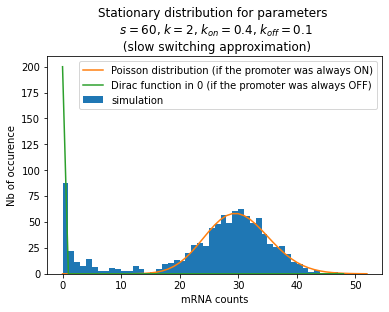

In [21]:
#Implementation of the beta-poisson mixture and test of its performances

def fastTelegraph(s,k,k_on,k_off, size=2000):
    """ This function simulate @size samples from mRNA counts
    distributed according the stationnary distribution of
    the telegraph model, set up with parameters @param."""
    r=np.random.beta(k_on/k,k_off/k,size)
    counts_per_cells=[np.random.poisson(s/k*r[i]) for i in range(size)]
    return counts_per_cells


s,k,k_on,k_off = 60, 2, 0.4, 0.1
possible_counts = np.array(range(max_count))
size=1000

cell_counts = fastTelegraph(s,k,k_on,k_off,size)
max_count = max(cell_counts)
nb_counts = len(cell_counts)


plt.hist(cell_counts,bins=max_count)
plt.plot(Poisson(s/k,possible_counts)*size*k_on/(k_on+k_off))
plt.plot(u(max_count)*size*k_off/(k_on+k_off))
plt.title("Stationary distribution for parameters \n $s=60$, $k=2$, $k_{on}=0.4$, $k_{off}=0.1$\n (slow switching approximation)")
plt.xlabel("mRNA counts")
plt.ylabel("Nb of occurence")
plt.legend(['Poisson distribution (if the promoter was always ON)', 'Dirac function in 0 (if the promoter was always OFF)','simulation',])
plt.show()

## Bibliography :

[1] : Grima, R., & Esmenjaud, P. M. (2023). Quantifying and correcting bias in transcriptional parameter inference from single-cell data. Biophysical Journal.